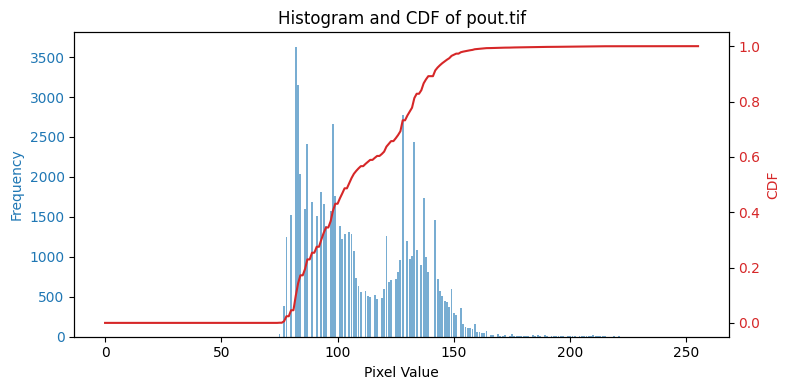

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio

def compute_cdf(image):
    """
    Compute the histogram and CDF of a grayscale image.
    """
    hist, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    cdf = np.cumsum(hist).astype(np.float32)
    cdf /= cdf[-1]  # Normalize to [0,1]
    return hist, cdf


image = iio.imread("../TestImages/Week 1/pout.tif")

hist, cdf = compute_cdf(image)

fig, ax1 = plt.subplots(figsize=(8, 4))

color = 'tab:blue'
ax1.set_xlabel("Pixel Value")
ax1.set_ylabel("Frequency", color=color)
ax1.bar(range(256), hist, color=color, alpha=0.6, label="Histogram")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("CDF", color=color)
ax2.plot(range(256), cdf, color=color, label="CDF")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Histogram and CDF of pout.tif")
fig.tight_layout()
plt.show()


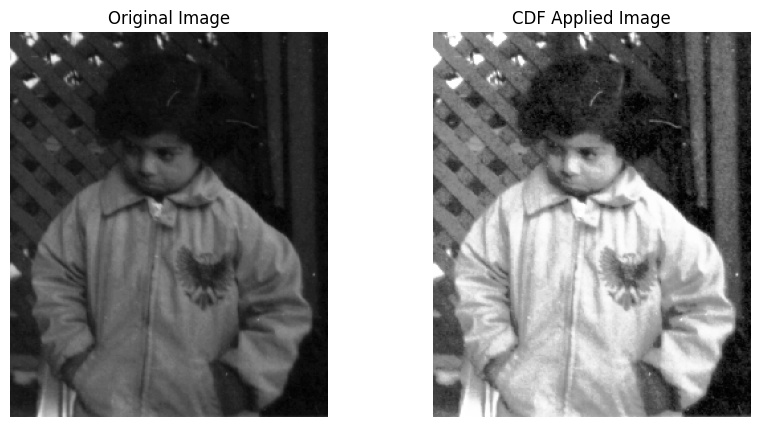

In [60]:
#4.2
def apply_cdf(image, cdf):
    """
    Apply the CDF transformation to the image.
    """
    cdf_mapped = np.round(cdf * 255).astype(np.uint8)
    equalized_image = cdf_mapped[image]
    return equalized_image

equalized_image = apply_cdf(image, cdf)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(equalized_image, cmap="gray")
plt.title("CDF Applied Image")
plt.axis("off")

plt.show()


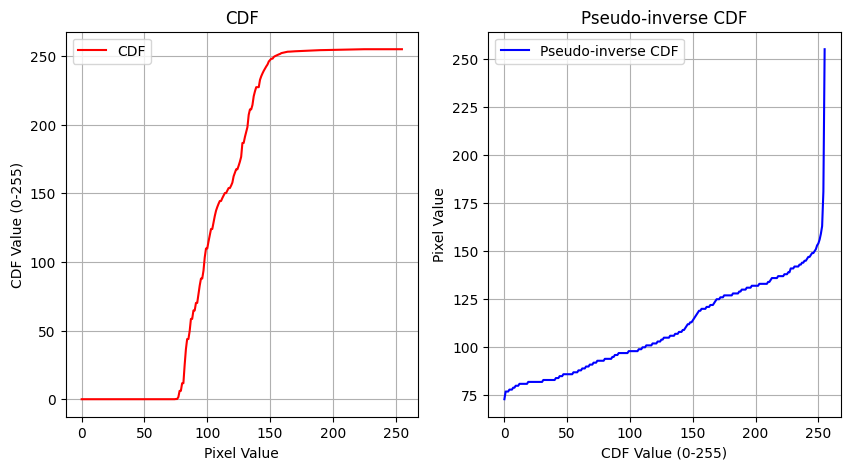

In [61]:
#4.3
# def compute_inverse_cdf(cdf):
#     """
#     Compute the pseudo-inverse of a given CDF.
#     Ensures proper intensity mapping for histogram matching.
#     """
#     inverse_cdf = np.zeros(256, dtype=np.uint8)
#
#     min_cdf_value = np.min(cdf)
#     max_cdf_value = np.max(cdf)
#
#     for l in range(256):
#         indices = np.where(cdf >= (l / 255.0) * (max_cdf_value - min_cdf_value) + min_cdf_value)[0]
#         if len(indices) > 0:
#             inverse_cdf[l] = indices[0]  # Take the first valid index
#         else:
#             inverse_cdf[l] = 255  # Default to max intensity if no match
#
#     return inverse_cdf
def compute_inverse_cdf(cdf):
    """
    Compute a smoothed pseudo-inverse of a given CDF using interpolation.
    This ensures better intensity mapping for histogram matching.
    """
    intensity_levels = np.linspace(0, 255, 256)
    inverse_cdf = np.interp(np.linspace(0, 1, 256), cdf, intensity_levels)
    return np.clip(np.round(inverse_cdf), 0, 255).astype(np.uint8)


inverse_cdf = compute_inverse_cdf(cdf)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(256), cdf * 255, color="red", label="CDF")
plt.title("CDF")
plt.xlabel("Pixel Value")
plt.ylabel("CDF Value (0-255)")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(256), inverse_cdf, color="blue", label="Pseudo-inverse CDF")
plt.title("Pseudo-inverse CDF")
plt.xlabel("CDF Value (0-255)")
plt.ylabel("Pixel Value")
plt.grid()
plt.legend()

plt.show()




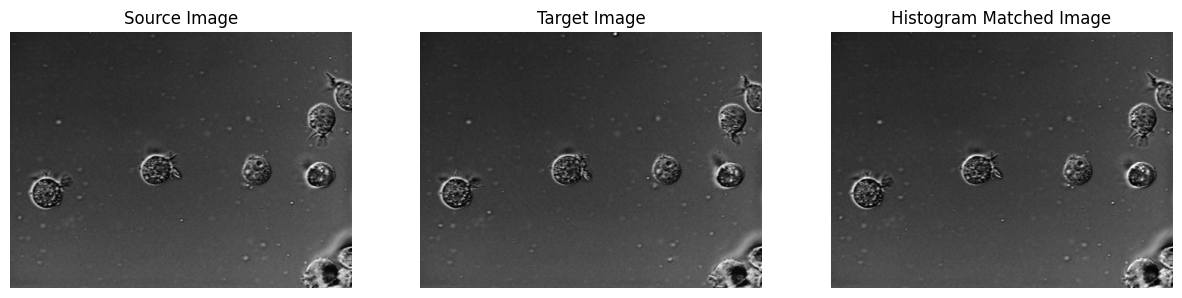

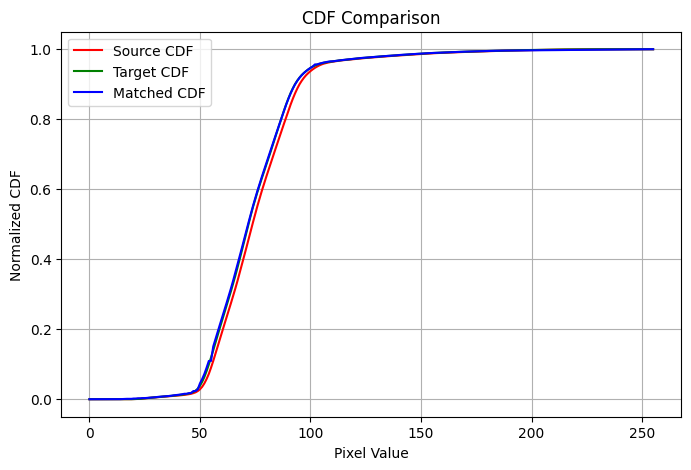

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio

def ensure_numpy_array(cdf):
    """
    Ensure that the given CDF is a NumPy array.
    If it's a tuple, extract the first element and convert it to an array.
    """
    if isinstance(cdf, tuple):
        cdf = np.array(cdf[0])
    else:
        cdf = np.array(cdf)
    return cdf

def histogram_matching(source_image, target_image):
    """
    Perform histogram matching using corrected pixel mapping.
    """
    _, cdf_source = compute_cdf(source_image)  # Compute CDF of source image
    _, cdf_target = compute_cdf(target_image)  # Compute CDF of target image
    inverse_cdf_target = compute_inverse_cdf(cdf_target)  # Compute pseudo-inverse

    # Step 1: Normalize source image intensity to CDF space
    source_cdf_values = cdf_source[source_image]

    # Step 2: Map source CDF values to target intensity values
    matched_image = np.interp(source_cdf_values, np.linspace(0, 1, 256), inverse_cdf_target)

    # Step 3: Convert to uint8 and clip values
    matched_image = np.clip(matched_image, 0, 255).astype(np.uint8)

    return matched_image

# Load the source and target images
source_image = iio.imread("../TestImages/Week 1/AT3_1m4_01.tif")
target_image = iio.imread("../TestImages/Week 1/AT3_1m4_02.tif")

# Compute target CDF and inverse CDF
_, cdf_target = compute_cdf(target_image)
inverse_cdf_target = compute_inverse_cdf(cdf_target)


# Perform histogram matching
matched_image = histogram_matching(source_image, target_image)

# Display the original, target, and matched images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(source_image, cmap="gray")
plt.title("Source Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(target_image, cmap="gray")
plt.title("Target Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(matched_image, cmap="gray")
plt.title("Histogram Matched Image")
plt.axis("off")

plt.show()

# Compute CDFs for comparison
_, cdf_source = compute_cdf(source_image)
_, cdf_matched = compute_cdf(matched_image)

# Plot CDF comparison
plt.figure(figsize=(8, 5))
plt.plot(range(256), cdf_source, label="Source CDF", color="red")
plt.plot(range(256), cdf_target, label="Target CDF", color="green")
plt.plot(range(256), cdf_matched, label="Matched CDF", color="blue")
plt.title("CDF Comparison")
plt.xlabel("Pixel Value")
plt.ylabel("Normalized CDF")
plt.legend()
plt.grid()
plt.show()
